Status:  ✅ done 

## Exercise 21

---

Welcome to the 21st exercise session, we are back to `generative models`. So far, we have talked about QDA and LDA. This session will be about `Naive Bayes`. To refresh your knowledge on this model, I suggest you read my [quick note](https://www.notion.so/ludekcizinsky/Generative-models-cb5b9346a8af41a8aaf0e80855afdcb1#7f1d9d898f724d0590868de565eca10c). I will also go over this quickly in the below theory section.

After this session, you should be able to:
- explain how `Naive Bayes` (NB) works - how we train it and how we make predictions
- describe the difference between NB and other generative models discussed in this course - QDA and LDA
- on a related note to the previous learning goal, you should also be able to describe for what kind of datasets/problems NB might be suitable 

> Imports

In [14]:
import math

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style("whitegrid");

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score

### 🏷 Theory behind Naive Bayes

---

> Fundamental information about Naive Bayes model

Recall from the lectures about genertive models that we are interested in modelling **posterior probability provided class given our input x**:

$
p(C_k |x) = \frac{p(x|C_k)p(C_k)}{p(x)}
$

As we can see from the formula, we essentially need to estimate two terms:
- $p(C_k)$: `prior probability` 
- $p(x|C_k)$: `class conditional probability`

To estimate priors, we simply use the maximum likelihood estimate, i.e.,

$
p(C_k) = \frac{n_k}{n}
$

where $n$ is total number of training samples and $n_k$ is the number of training samples of a particular class $k$. **Now, the most important part.** In case of `LDA` and `QDA` we assumed that features in the input $x$ might be dependent on each other, i.e., there is a certain correlation among them. For instance, if your task is to classify if I am proffesional runner or just an amateur, you might look at features like number of km run per week, personal best for distances like 5k, 10k etc. We can assume that there is a certain dependence between these since the more I run per week determines what is my personal best for let's say 10k race. Sorry, this is the best example I could come up at the moment. **Well, guess what, Naive Bayes assumes independence between features hence its name - naive.**

What does this assumption influence? While in case of `QDA` and `LDA` we would model the class conditional probability using **multivariate normal distribution** which requires to specify a vector of means for each respective feature as well as the covariance matrix. Note that it might happen that our estimated covariance matrix is equivalent to identity matrix, i.e., it has only 1s along main diagonal - meaning all features are independent. But in case of Naive Bayes, we simply rule out the option of dependence and just assumme in the independence right from the beggining. Thererfore we for each class conditional probability we write:

$
p(C_k|x) \sim \prod_j^m p(x_j|C_k)
$

In words, we estimate the probability of each feature given the class $k$ independently and then we take the product of all probabilities of the features. Now, a natural question arises:

> how do we estimate the class conditional probability for each feature, i.e., $p(x_j, C_k)$?


You can use your creativity and essentially model it with whatever method you feel is best suited. However, to be more specific, most commonly, you will use one of these approaches (at least within the bounds of this course):

1. If $x_j$ is **quantitative**, one of the options is to model it as follows (**parametric way**):
    
    $
    p(x_j|C_k) \sim N(\mu_{jk}, \sigma^2_{jk})
    $
    
    In words, we assume that each feature for given class is drawn from **normal distribution**. This might seem relatively similar to QDA in a sense that for each class, we model its own mean and variance, however, there is one core difference, we assume feature independence. And as such, it would be the same as QDA only if QDA would have each $\Sigma_k = I$. Finally, we could use any other distribution, the normal distribution is just used as an example.
    
2. Alternatively, we can approximate **quantitative** feature $x_j$ using a **non-parametric** method:
    1. Using a `histogram` for given feature $x_j$ from class $k$. 
    2. Using `kernel density` estimate which is a smoother version of the histogram method.
3. If $x_j$ is **qualitative**, we can simply use frequentist based approach. This means that to each unique value within feature $x_j$ from class $k$ we assign a probability based on its frequency.

We will practice these approaches in the below subsection.

> Estimating probabilities using histogram and kernel density estimates

We are given following set of 5 points in the plot:

![Points plot](points.png)

Our task will be to draw histograms and kernel density based on these, for a reference I also provide their numerical values:

In [2]:
points = [-.8, -.15, .25, .3, 1.1]

Let's start with **histograms**. Histograms estimates the probability (density) of some continuous feature $x$ as follows:

$
\hat{f}(x)=\frac{\text { No. of observations in bin containing } \mathrm{x}}{n h}
$

where $n$ denotes the number of training samples and $h$ is the bin width. I assume that you have usually encountered histograms with a fixed bin width $h$, but this can also vary. For instance, if you have a very skewed distribution of points, then in the range where there is a lot points, you want to make the bin width small whereas for the range where points are sparse you want to make it wide. For this reason, we just do not divide by $n$ but by $nh$ which means:
> if you increase bin width $h$, you can assume to capture more points, therefore, you want to account for this by divind the count by a higher number and vice versa.



Let's try to plot two histograms with the same bin width however over a different interval:

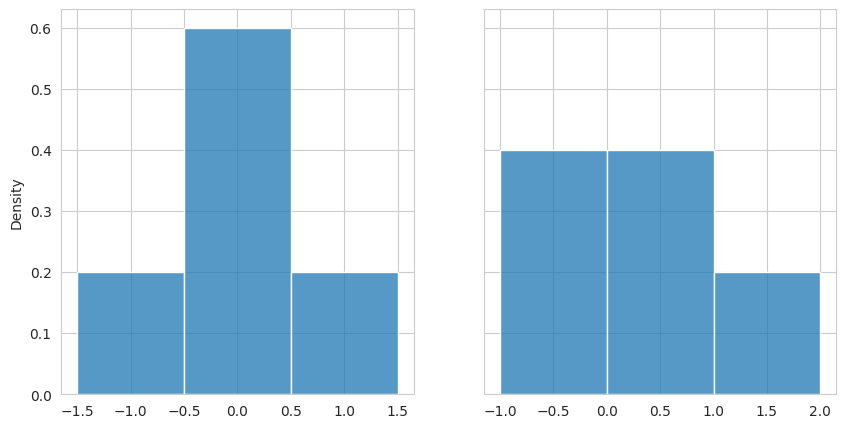

In [3]:
# Define plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Show the plots
sns.histplot(x=points, binwidth=1, ax=axs[0], bins=3, binrange=(-1.5, 1.5), stat='density');
sns.histplot(x=points, binwidth=1, ax=axs[1], bins=3, binrange=(-1, 2), stat='density');

You can see that such choice as `range` can dramatically influence the estimates if the number of points is very small as is in our particular example. Now, let's move to the **kernel density estimation**. Here, we shift our perspective from groupping observations into bins and rather focus on individual points and their close neighborhod:

$
\hat{f}(x)=\frac{\text { No. of observations in }[x-h ; x+h]}{n \cdot 2 h} \text {. }
$

To determine how close we are talking, we use a hyper-parameter $h$. This is essentially similar to bin width in the previous case, but this time we use the $h$ in both directions from $x$, therefore we normalize the estimate by $n\cdot 2h$. However, if we want a smooth density estimate, then we can use instead the ’Gaussian’ kernel. That would place a Gaussian bell curve in each observation rather than a constant function, so the further away from x they are, the less they contribute to the estimated pdf value f(x). This is in fact how `seaborn does it`, let's try: 

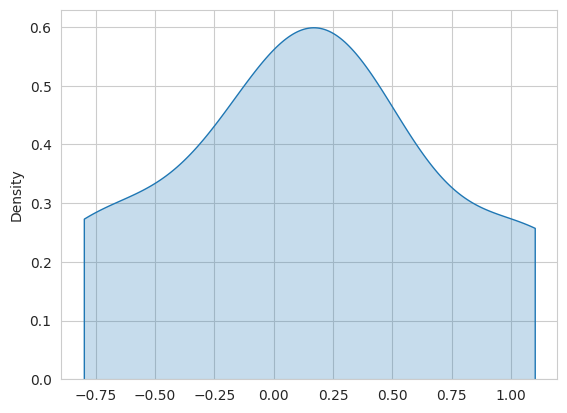

In [4]:
# Define plot
fig, ax = plt.subplots()

# Show the plot
sns.kdeplot(x=points, ax=ax, fill=True, bw_method=1/2, cut=0);

> Section summary

After this section, you should be able:
- what `Naive Bayes` (NB) is and how we train it
- explain how we can estimate individual conditional probabilities using methods such as `histogram` or `kde`

### 🏷 Data exploration

---

In this section, we will load and explore data that we will then use in subsequent sections. Let's first load the data:

In [5]:
# Training
training = pd.read_csv("Ex21-training.csv")
X_train, y_train = training[["x1", "x2", "x3"]], training["y"]

# Test
test = pd.read_csv("Ex21-test.csv")
X_test, y_test = test[["x1", "x2", "x3"]], test["y"]

Next, let's look at the independence of features via plots:

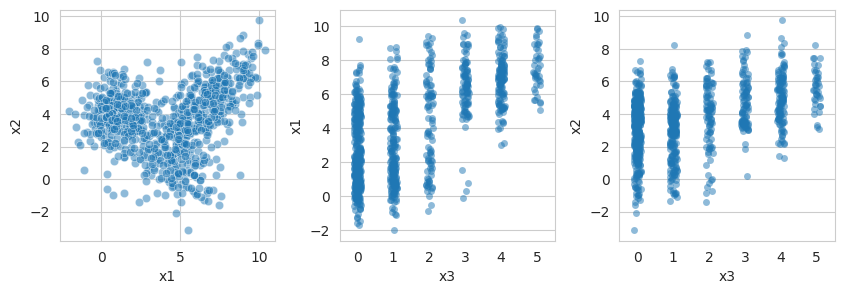

In [6]:
# Define figure
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
fig.subplots_adjust(wspace=0.3)

# x1 vs x2
sns.scatterplot(data=training, x="x1", y="x2", ax=axs[0], alpha=.5);

# x1 vs x3
sns.stripplot(data=training, x="x3", y="x1", ax=axs[1], alpha=.5);

# x2 vs x3
sns.stripplot(data=training, x="x3", y="x2", ax=axs[2], alpha=.5);

For the first subplot, we can see that there is clearly some non-linear dependence. For the other two plots, we can also see that the value of the categorical variable influences the distribution of the given continuous variable. Therefore, for this dataset, model like `Naive Bayes` might not be the best given its assumption of independence of features. Further, let's look at the distribution of each feature separately:

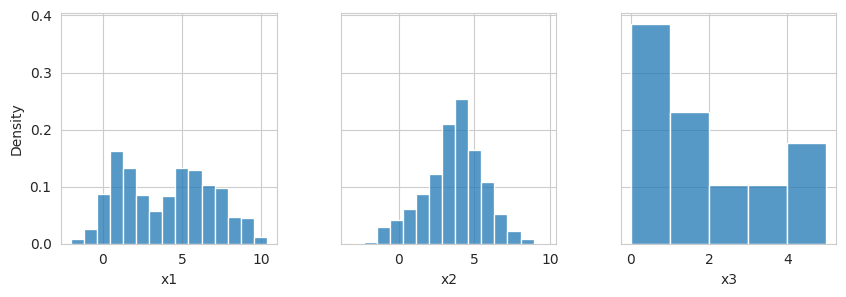

In [7]:
# Define figure
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
fig.subplots_adjust(wspace=0.3)

# x1
sns.histplot(data=training, x='x1', ax=axs[0], stat='density', bins=15);

# x2
sns.histplot(data=training, x='x2', ax=axs[1], stat='density', bins=15);

# x3
sns.histplot(data=training, x='x3', ax=axs[2], stat='density', bins=5);

We can see that the only feature which is following normal distribution is `x2`. This is again important to consider further down the road when choosing appropriate model since for instance `LDA` and `QDA` assume normal distribution for each feature.

### 🏷 Implementation of Naive Bayes

---

> Intro to the problem

In this section, our focus will be on implementing `Naive Bayes classifier`. We will then use it in the next section to compare to other classifiers. Here is my personal high level approach on how to tackle the implementation the model should have
- fit method that:
    - estimates `class priors`
    - estimates `class conditionals`
- predict probability method that:
    - will compute `posterior probability` for given sample and all classes
- predict method:
    - that predicts single class for given sample using certain `decision rule` (assuming 0-1 loss, we will predict class with highest posterior probability)

The challenge about this implementation is that you have to estimate a lot of things. For this reason, it is essential to choose proper datastructures that enable you to find the given PDF/PMF estimate easily. In my implementation, I use python `dict`.

> Implementation

In [8]:
class NaiveBayesClf:
    """NaiveBayesClassifier

    Note that `h` refers to the bandwidth used
    for estimation of the PDF for given continous variable.
    """
    def __init__(self, h, pdf_estimator='hist'):
        # User defined attributes
        self.h = h
        self.pdf_estimator = pdf_estimator

        # Private instance attributes
        self._priors = None
        self._conditionals = None
        self._feature_type = []
    
    def _estimate_pmf(self, X, cl, j):
        """Estimates the probability mass
        function of the given categorical variable.
        """
        total = X.shape[0]
        values, counts = np.unique(X, return_counts=True)
        self._conditionals[cl][j] = {val: count/total for val, count in zip(values, counts)}
    
    def _hist_estimator(self, X, cl, j):
        """Estimates the PDF of the given
        continous variable via histogram bins, i.e.,
        it splits the range of the X into intervals/bins
        and then maps each bin to corresponding density.
        """
        bins = math.ceil((X.max() - X.min()) / self.h)
        d, edges = np.histogram(X, density=True, bins=bins)
        self._conditionals[cl][j] = [[upper_bound, d] for upper_bound, d in zip(edges[1:], d)]

    def _estimate_pdf(self, X, cl, j):
        """Estimates the probability density
        function of the given continuous variable
        """
        if self.pdf_estimator == 'hist':
            self._hist_estimator(X, cl, j)
        elif self.pdf_estimator == 'kde':
            self._conditionals[cl][j] = stats.gaussian_kde(X)
        else:
            print(f"{self.pdf_estimator} not implemented!")

    def fit(self, X, y):
        """
        Note: feature is considered continuous if its datatype is float,
        else it is categorical.
        """
        
        # Estimate priors
        total = X_train.shape[0]
        cls, counts = np.unique(y, return_counts=True)
        self._priors = {cl : count/total for cl, count in zip(cls, counts)}

        # Initialize the class conditionals dictionary
        self._conditionals = {cl : dict() for cl in self._priors.keys()}

        # Estimate class conditional distribition of features
        for cl in cls:

            # Extract data specific to the given class
            Xcl, ycl = X[y == cl], y[y == cl]

            # For each feature estimate its distribution using given method
            for j in range(X.shape[1]):
                
                # Extract feature
                f = Xcl.iloc[:, j]

                # Extract feature type
                isfloat = "float" in str(f.dtype)
                
                # Estimate the PDF/PMF
                if isfloat:
                    self._estimate_pdf(f, cl, j)
                else:
                    self._estimate_pmf(f, cl, j)
        
        # Extract feature type
        for j in range(X.shape[1]):
            isfloat = "float" in str(X.iloc[:, j].dtype)
            if isfloat:
                self._feature_type.append("cont")
            else:
                self._feature_type.append("cat")

    def _get_feature_probability(self, f, cl, j):
        if self.pdf_estimator == 'hist':
            dist = self._conditionals[cl][j]
            if self._feature_type[j] == 'cat':
                return dist.get(f, 0)
            else:
                for upper_bound, d in dist:
                    if f < upper_bound:
                        return d
                return d
        else:
            dist = self._conditionals[cl][j]
            if self._feature_type[j] == 'cat':
                return dist.get(f, 0)
            else:
                return dist.pdf(f)[0]

    def predict_proba(self, X):
        """Estimate posterior probabilities for each sample
        for all possible classes.
        """
        if self._priors is None:
            raise ValueError("Model has not been fitted yet.")

        n, m, k = X.shape[0], X.shape[1], len(self._priors)
        probs = np.empty((n, k))

        # For each sample compute the posterior probabilities array 1 x k
        # where k is the number of classes
        for i in range(n):
            x = X.iloc[i]
            likelihoods = []
            for cl in self._priors.keys():
                # likelihood = p(C_k)p(x|C_k)
                likelihood = self._priors[cl]
                for j in range(m):
                    f = x[j]
                    likelihood *= self._get_feature_probability(f, cl, j)
                likelihoods.append(likelihood)
            
            # Turn likelihoods into posterior probabilities by normalizing them
            total = sum(likelihoods)
            posterior = np.array(likelihoods)/total

            # Save the posteriors
            probs[i] = posterior
        
        return probs

    def predict(self, X, offset=0):
        """I added the offset variable to account for the cases where the target
        variables are not zero based, if for instance they start at 1, then offset is 1 etc.
        """        
        if self._priors is None:
            raise ValueError("Model has not been fitted yet.")

        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1) + offset

> Test of the implementation

Let's test the implementation out. First, we will train the model using `hist` estimate for `PDFs` of continuous features:

In [9]:
# Define the model
nbclf = NaiveBayesClf(h=2)

# Train
nbclf.fit(X_train, y_train)

# Evaluate
yhat = nbclf.predict(X_test, offset=1)
f1 = f1_score(y_test, yhat)
print("F1-score of the model is {:.3f}".format(f1))

F1-score of the model is 0.982


Now, let's try with `KDE`:

In [12]:
# Define the model
nbclf = NaiveBayesClf(h=2, pdf_estimator='kde')

# Train
nbclf.fit(X_train, y_train)

# Evaluate
yhat = nbclf.predict(X_test, offset=1)
f1 = f1_score(y_test, yhat)
print("F1-score of the model is {:.3f}".format(f1))

F1-score of the model is 0.988


Nice, we see that we have obtained even slightly better performance! Note that here I chose `h = 2` with no particular reason, if you wanted to make this more formally, then you could use something like `GridSearch` which is a way how to find the most optimal set of `hyper-parameters` for the given model. 

> Section summary

The goal of this section was clear: implement `Naive Bayes Classifier`. I believe the main learning point of this exercise was to simply be able to translate the theoretical knowledge into code. Here, the major challenge of course was that there was a lot of things to compute and as such one could get easily lost in details. In such cases, you have to advance by small steps and make sure after each step that things work as you would expect otherwise you will find yourself debugging large pile of code - not fun.

### 🏷 Finding the optimal classifier

---

> Intro to the section

In this section, we will focus on finding the most optimal model for provided dataset. We will play around with using different models as well as different set of features.

> LDA and QDA

Let's start with trying out LDA and QDA. First, we will fit the models and evaluate their peformance:

In [11]:
# Define models
ldclf = LinearDiscriminantAnalysis()
qdclf = QuadraticDiscriminantAnalysis()

# Group to a single list so we can iterate over
models = [(ldclf, "LDA",), (qdclf, "QDA",)]

# Train and evaluate
for model, name in models:

    # Train
    model.fit(X_train[["x1", "x2"]], y_train)

    # Evaluate
    yhat = model.predict(X_test[["x1", "x2"]])
    f1 = f1_score(y_test, yhat)
    print("F1-score of {} is {:.3f}".format(name, f1))

F1-score of LDA is 0.954
F1-score of QDA is 0.964


We see that we have obtained slightly worse performance.

> KNN

Let's try to train `KNN` models on `x1` and `x2` individually and then combined:

In [16]:
# Group to a single list so we can iterate over
models = [(KNN(), ["x1"], "KNN1", ), (KNN(), ["x2"], "KNN2",), (KNN(), ["x1", "x2"], "KNN1a2",)]

# Train and evaluate
for model, data, name in models:

    # Train
    model.fit(X_train[data], y_train)

    # Evaluate
    yhat = model.predict(X_test[data])
    f1 = f1_score(y_test, yhat)
    print("F1-score of {} is {:.3f}".format(name, f1))

F1-score of KNN1 is 0.896
F1-score of KNN2 is 0.797
F1-score of KNN1a2 is 0.964


Clearly, we can see that feature `x1` is more signifficant when it comes to discriminating between the two classes, however, `x2` is not completely useless either since we still get a bit of the performance gain. However, overall, the overall best performance was achieved using our own `NaiveBayes` classifier. Looking at the scatterplot between `x1` and `x2`, despite we see there is some dependence, we could say that it is not that strong, therefore the independence assumption of the Naive Bayes is not completely off and as such the model achieves best performance.

> Section summary

In this section, we tried to train different models to solve the given classification problem. The aim of this exercise was to practice tackling given machine learning problem using the learnt knowledge. This means:
- being able to explore the data and describe its important characteristics (e.g. normal distribution, ...)
- based on the data and also some other objectives such as explainability of the model, select the set of best possible models
- choose a proper metric to measure the performance of the set of models
- choose the best model and be able to argue for this particular choice

With this being said, I conlude the 21st exercise session!

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d351dd26-1bb5-4bff-8ecc-97027c907b60' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>